# Posture Classifier

Experimenting with recording data

Aiming to train classifier models, measure accuracy ___________________________________________

In [234]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
import yellowbrick
from yellowbrick.features import RadViz
from yellowbrick.model_selection import FeatureImportances
from sklearn.gaussian_process import GaussianProcessClassifier


## Loading and Visualizing

In [ ]:
!ls ../data/raw

In [3]:
g_record = 'data/raw/datalog_at_2021-06-12_18_10_15.450479'
c_record = 'data/raw/datalog_at_2021-06-12_18_39_06.887277'

In [4]:
df_g = pd.read_csv('../' + g_record)
df_c = pd.read_csv('../' + c_record)

In [5]:
df_g.columns

Index(['Ax', 'Ay', 'Az', 'Temperature', 'gx', 'gy', 'gz', 'FlexSensor',
       'Label'],
      dtype='object')

In [236]:
df_g

,Ax,Ay,Az,Temperature,gx,gy,gz,FlexSensor,Label
0,-0.223877,-0.972412,-0.151367,29.9418,-3.28244,0.175573,1.595420,521,NaN
1,-0.253418,-0.961670,-0.161621,29.9418,-10.23660,-14.442700,0.320611,519,NaN
2,-0.245117,-0.974854,-0.158936,29.9418,-7.53435,-13.618300,-0.847328,520,NaN
3,-0.238770,-0.964355,-0.152588,29.9418,-5.48092,-9.351150,0.755725,518,NaN
4,-0.224609,-0.976562,-0.150391,29.9418,-5.19847,-4.450380,1.152670,521,NaN
...,...,...,...,...,...,...,...,...,...
2695,0.735596,-0.584961,-0.610840,30.5065,-3.39695,1.442750,1.618320,508,t
2696,0.741943,-0.594238,-0.627197,30.6006,-3.38168,0.725191,1.770990,511,t
2697,0.737549,-0.584229,-0.612549,30.6006,-3.00000,-0.076336,1.351150,511,t
2698,0.743652,-0.585205,-0.621094,30.6006,-2.88550,-2.251910,1.893130,509,t


### Visualize

In [8]:
df_g['Label'].unique()

array([nan, 't', 'e', 'c', 'm'], dtype=object)

In [9]:
pd.DataFrame.dropna?

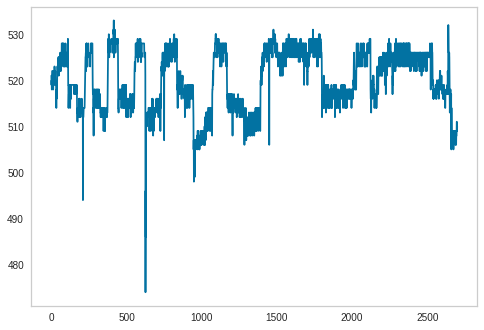

In [239]:
plt.plot(df_g['FlexSensor'])
plt.grid()
plt.show()

In [245]:
def plot_positions_from_df(df_g, categories, value_col):
    df_g.dropna(axis=0)
    plt.plot(df_g[value_col], c='grey', alpha=0.3)
    for c in categories:
        c = df_g[df_g['Label'] == c][value_col]
        plt.scatter(c.index, c.values, marker='.', lw=[0.05]*len(c.index))
#     plt.ylim((490, 550))
    plt.grid()
    plt.show()

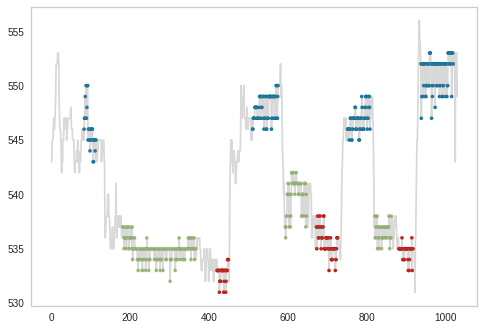

In [246]:
plot_positions_from_df(df_c, ['e', 'c', 'm'], 'FlexSensor')

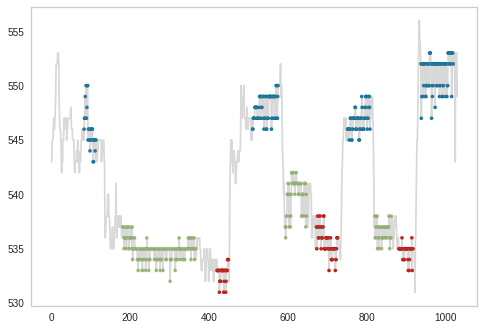

In [242]:
plot_positions_from_df(df_c,  ['e', 'c', 'm'], 'FlexSensor')

In [ ]:
label_encoder = {'e': 1, 'c': 0, 'm': 0}
df_for_corr = df_g.dropna(axis=0)
df_for_corr = df_for_corr[df_for_corr['Label'] != 't']
df_for_corr['fake_label'] = df_for_corr['Label'].apply(lambda x: label_encoder[x])

In [19]:
df_for_corr.corr()


,Ax,Ay,Az,Temperature,gx,gy,gz,FlexSensor
Ax,1.000000,-0.296258,-0.712417,0.055898,0.040854,0.024084,0.008007,-0.705901
Ay,-0.296258,1.000000,0.004407,0.152480,-0.062315,-0.084199,0.031259,0.381584
Az,-0.712417,0.004407,1.000000,-0.116895,0.018114,0.026393,0.011102,0.488201
Temperature,0.055898,0.152480,-0.116895,1.000000,-0.023252,-0.058227,0.016534,-0.114448
gx,0.040854,-0.062315,0.018114,-0.023252,1.000000,0.727826,0.354546,-0.014910
gy,0.024084,-0.084199,0.026393,-0.058227,0.727826,1.000000,0.129118,-0.017224
gz,0.008007,0.031259,0.011102,0.016534,0.354546,0.129118,1.000000,0.033815
FlexSensor,-0.705901,0.381584,0.488201,-0.114448,-0.014910,-0.017224,0.033815,1.000000


## Preparing Data

In [258]:
def parse_dataset(df):
    replace_label = {'t': None, 'e': 0, 'c': 1, 'm': 0}
    data = df.copy()
    data['Label'] = data['Label'].apply(
        lambda x: replace_label[x] if x is not np.nan else None
    )

    data = data.drop(columns='Temperature').dropna(axis=0)
    data['Label'] = data['Label'].astype('int')
    return data

In [259]:
data = parse_dataset(df_g)
y = data['Label']
X = data.drop(columns='Label')

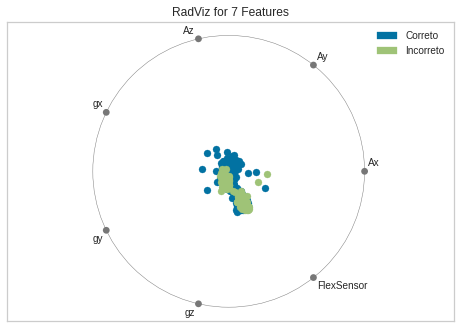

In [261]:
visualizer = RadViz(classes=['Correto', 'Incorreto'])
visualizer.fit(X, y.values)
visualizer.transform(X)
visualizer.show()
plt.show()

## Modelling
### Choosing models

In [256]:
lda_model = LinearDiscriminantAnalysis(
    solver='lsqr'
)

In [257]:
qda = QuadraticDiscriminantAnalysis()

In [134]:
ridge_model = RidgeClassifierCV()

In [182]:
kn_model = KNeighborsClassifier()

In [186]:
# gpc_model = GaussianProcessClassifier()

In [229]:
ada_model = AdaBoostClassifier()

In [230]:
forest_clf = RandomForestClassifier()

## Evaluating Models

In [170]:
def get_model_comparisons(model_register):
    results = {}
    for mn, model in model_register:
        scores = model_selection.cross_validate(
            model, X, y,
            cv=50,
            scoring=('accuracy', 'f1'),
            return_train_score=True
        )
        results.update({mn: pd.DataFrame(scores).mean().to_dict()})
    result = pd.DataFrame(results).drop(index=['fit_time', 'score_time'])
    return result

In [231]:
model_register = [
    ('lda', lda_model),
    ('ridge', ridge_model),
    ('qda', qda),
    ('kn', kn_model),
    ('forest_clf', forest_clf),
    ('ada_model', ada_model),
    # ('gpc_model', gpc_model),
]

df_compare = get_model_comparisons(model_register)
df_compare


,lda,ridge,qda,kn,forest_clf,ada_model
test_accuracy,0.648437,0.623701,0.818230,0.838299,0.966368,0.959379
train_accuracy,0.689739,0.669373,0.827548,0.900414,1.000000,0.989158
test_f1,0.276536,0.128405,0.817439,0.720889,0.940631,0.932620
train_f1,0.346647,0.188689,0.766874,0.831156,1.000000,0.981730


In [207]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.5
)
kn_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [271]:
kn_confusion_matrix = sklearn.metrics.confusion_matrix(
    y_test,
    kn_model.predict(X_test),
    normalize='true',
)
kn_confusion_matrix *= 100

array([[92.05426357,  7.94573643],
       [18.86792453, 81.13207547]])

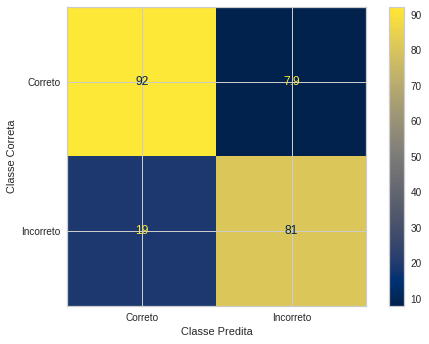

In [292]:
sklearn.metrics.ConfusionMatrixDisplay(
        kn_confusion_matrix,
        display_labels=['Correto', 'Incorreto']
    ).plot(cmap='cividis', values_format='.2g')
plt.ylabel('Classe Correta')
plt.xlabel('Classe Predita')
plt.show()

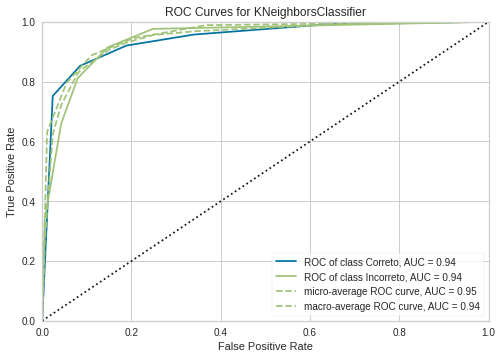

In [274]:
roc_auc_viz = yellowbrick.classifier.ROCAUC(kn_model, classes=['Correto', 'Incorreto'])
roc_auc_viz.fit(X_train, y_train)
roc_auc_viz.score(X_test, y_test)
roc_auc_viz.show()
plt.show()


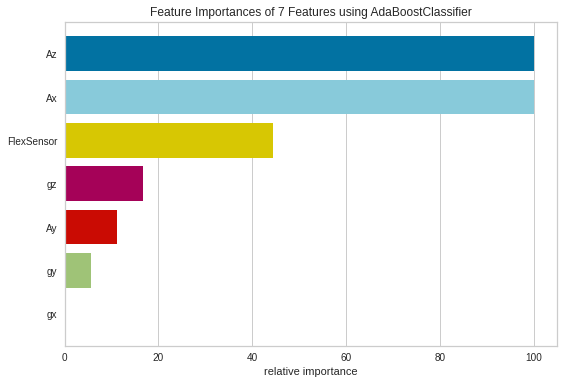

In [265]:
feature_viz = FeatureImportances(AdaBoostClassifier())
feature_viz.fit(X, y)
feature_viz.show()
plt.show()